In [19]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [20]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [21]:
k = 10 # Top 10% highest l2-magnitude filters

In [41]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []
for l_num, l in enumerate(conv_layers):
    print(f" ============ LAYER {l_num} ==================")
    top10F=topKfilters(model, l_num, k=k)
    beta_f = []
    for f in top10F:
        top10C = topKchannels(model, l_num, f, k=k)

        filters = tf.expand_dims(get_filter(model, l_num)[:,:,top10C, f], -1)
        s, a = getSymAntiSymTF(filters)
        a_energy = reduce_euclidean_norm(a, axis=[0,1])**2
        s_energy = reduce_euclidean_norm(s, axis=[0,1])**2
        total_energy  = reduce_euclidean_norm(filters, axis=[0,1])**2
        #beta = a_energy/total_energy
        beta_f.append(tf.reduce_mean(a_energy/total_energy))
    beta.append(beta_f)
    print(beta)
    e_beta.append(np.mean(beta[-1]))
    '''min_beta.append(e_beta[-1] - np.min(beta))
    max_beta.append(np.max(beta)-e_beta[-1])'''




 ============ LAYER 0 ==================
[[<tf.Tensor: shape=(), dtype=float32, numpy=0.66356236>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9087973>, <tf.Tensor: shape=(), dtype=float32, numpy=0.91104394>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9969793>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9997209>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8681362>]]
 ============ LAYER 1 ==================
[[<tf.Tensor: shape=(), dtype=float32, numpy=0.66356236>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9087973>, <tf.Tensor: shape=(), dtype=float32, numpy=0.91104394>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9969793>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9997209>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8681362>], [<tf.Tensor: shape=(), dtype=float32, numpy=0.0035362274>, <tf.Tensor: shape=(), dtype=float32, numpy=0.540005>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5546729>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8592329>, <tf.Tensor: shape=(), dty

In [31]:
beta_f

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0030643183>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5430781>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.59463006>]

In [ ]:
e_beta

[0.8913734,
 0.57749516,
 0.6857469,
 0.57314867,
 0.47667313,
 0.5382141,
 0.5858654,
 0.5233497,
 0.58639646,
 0.5390839,
 0.52602124,
 0.46240327,
 0.37830177]

In [29]:
beta_f

[<tf.Tensor: shape=(), dtype=float32, numpy=0.2996775>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.21999863>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.39906722>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.16668922>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.2593798>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08390025>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1441877>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.12725332>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.14072414>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11728577>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.17366904>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.095129624>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.19885392>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1388764>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.15953615>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.2583375>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08867142>,
 <tf.Tensor: shape=(), dtype=float3

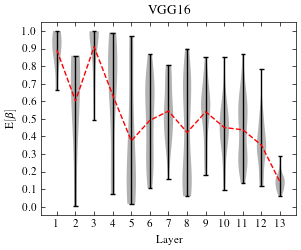

In [42]:
plt.violinplot(beta)
plt.plot(np.arange(1, len(conv_layers)+1), e_beta)
#plt.errorbar(np.arange(0, len(conv_layers)), e_beta, yerr = [min_beta, max_beta], fmt ='o')

plt.xlabel("Layer")
plt.ylabel(r"$\text{E}[\beta]$")
plt.xticks(np.arange(1, len(conv_layers)+1, step=1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('VGG16')

plt.minorticks_off()
plt.savefig('figures/vgg16_ebeta.png', dpi=600)
plt.show()
plt.close()